## Запускается на колабе

см. https://drive.google.com/drive/folders/1t-RrkkEU1cVZrpE0ZLnSt4O6Ti1N3176?usp=sharing

Можно сделать алиас на эту папку, чтобы работало. Но не получиться сохранять графики, потому что ссылка даёт доступ на читателя. Стоит закомментировать строчки:

`plt.savefig('/content/drive/MyDrive/m1p/figs/{}.png', bbox_inches='tight')`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm import tqdm
from typing import Dict
import time

import torch
import torch.fx
from torch.fx.node import Node

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

import sys
sys.path.append('/content/drive/MyDrive/m1p')

from fast_nas_adapt.src.resnet18 import ResNet18
from fast_nas_adapt.src.module2graph import GraphInterperterWithGamma


Тут был код, который замерял время. Сейчас он в файле

In [ ]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        for node in self.graph.nodes:
            if node.op == 'call_module':
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas =  torch.nn.Parameter(torch.as_tensor(gammas), requires_grad = True)
        self.discrete = False 

    def sample_gammas(self):
        if self.discrete:
            return self.gammas
        else:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            return d.rsample()
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>=0) * 1.0
        self.gammas.requires_grad = False 
        self.discrete = True

Получим претрейн на n эпох

In [ ]:
model = ResNet18(num_classes=10).cuda()

model_path = '/content/drive/MyDrive/m1p/pretrained/model_23.ckpt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
from fast_nas_adapt.src.cifar_data import get_dataloaders

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64,
                                    img_size=33)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
@torch.no_grad()
def validate(model, dataloader, device):
    model = model.to(device)
    n_true = 0
    n_tot = 0
    for i, (X, y) in tqdm(enumerate(dataloader), 'validating'):
        if X.shape[0] != 64:
            continue
        n_true += (model(X.to(device)).argmax(-1) == y.to(device)).sum().item()
        n_tot += 64
    return n_true / n_tot

In [ ]:
validate(model, test_dl, 'cuda')

validating: 157it [00:08, 19.02it/s]


0.6464342948717948

Гиперпараметры:

In [ ]:
device = 'cuda'

imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2).to(device)
optimizer = torch.optim.Adam([imodel.gammas], lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

times_path = "/content/drive/MyDrive/m1p/ResNet18HomeMeasurments.csv"
times = pd.read_csv(times_path, index_col=0)
times = torch.tensor(times['mean'], dtype=torch.float32).cuda()
times /= times.sum()
lambd = 2.0
print(imodel.gammas.sigmoid())

validate(imodel, test_dl, device), imodel.sample_gammas()

tensor([0.9967, 0.9961, 0.9591, 0.9941, 0.9742, 0.9790, 0.9800, 0.9877, 0.9833,
        0.9881, 0.9817, 0.9679, 0.9974, 0.8502, 0.9326, 0.9860, 0.9972, 0.9868,
        0.9964, 0.9941, 0.9840, 0.9927, 0.9917, 0.9267, 0.9556, 0.9863, 0.9877,
        0.9835, 0.9882, 0.9778, 0.9755, 0.9928, 0.9856, 0.9699, 0.9925, 0.9462,
        0.9684, 0.9952, 0.9773, 0.9481, 0.9692, 0.9911, 0.9687, 0.9746, 0.9333,
        0.9872, 0.9534, 0.8661, 0.9967, 0.9969, 0.9897, 0.9907, 0.9854, 0.9774,
        0.9949, 0.8727, 0.9704, 0.9967, 0.9795, 0.9826], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


validating: 157it [00:01, 99.54it/s] 


(0.10176282051282051,
 tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 9.9810e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9054e-01,
         9.9984e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 9.9999e-01, 9.7148e-01, 1.0000e+00, 1.0019e-02,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9998e-01, 9.9998e-01, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.6235e-04, 9.9460e-01, 1.0000e+00, 9.9999e-01, 9.9998e-01],
        device='cuda:0', grad_fn=<ClampBackward1>))

In [ ]:
### TEST
with torch.no_grad():
    x = torch.randn(64, 3, 32, 32).to(device)
    print(model(x).shape, imodel(x).shape)
    # assert (model(x) - imodel(x)).abs().mean().item() < 2

torch.Size([64, 10]) torch.Size([64, 10])


In [ ]:
def discrete_copy(imodel):
    result = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2).to(device)
    result.load_state_dict(imodel.state_dict())
    result.make_gammas_discrete()
    return result

In [ ]:
EPOCHS = 10

best_acc = 0.0
epoch_history = []
val_accs = []


for epoch in range(EPOCHS):
    print(f'EPOCH {epoch}:')

    imodel.train()

    for i, (X, y) in tqdm(enumerate(train_dl), 'training', total=len(train_dl)):
        if X.shape[0] != 64:
            continue

        optimizer.zero_grad()
        y_pred = imodel(X.to(device))
        loss = loss_fn(y_pred, y.to(device)) + lambd * imodel.sample_gammas().dot(times)
        loss.backward()
        optimizer.step()

        epoch_history.append((y_pred.argmax(-1) == y.to(device)).float().mean().item())
        
    avg_loss = np.mean(epoch_history)

    imodel.eval()

    val_acc = validate(discrete_copy(imodel), test_dl, device)
    val_accs.append(val_acc)
    print('LOSS train {} valid {}'.format(avg_loss, val_acc))

    # Track best performance, and save the model's state
    if val_acc > best_acc:
        print(f'impoved ({epoch}epoch): old: {best_acc}; new: {val_acc};')
        best_acc = val_acc
        model_path = f'/content/drive/MyDrive/m1p/pruned/model_{lambd}.ckpt'
        torch.save(imodel.state_dict(), model_path)

EPOCH 0:


training: 100%|██████████| 782/782 [00:21<00:00, 36.73it/s]
validating: 157it [00:01, 112.91it/s]


LOSS train 0.6847191101152369 valid 0.37940705128205127
impoved (0epoch): old: 0.0; new: 0.37940705128205127;
EPOCH 1:


training: 100%|██████████| 782/782 [00:22<00:00, 34.99it/s]
validating: 157it [00:01, 111.29it/s]


LOSS train 0.6827584827144686 valid 0.42197516025641024
impoved (1epoch): old: 0.37940705128205127; new: 0.42197516025641024;
EPOCH 2:


training: 100%|██████████| 782/782 [00:24<00:00, 32.03it/s]
validating: 157it [00:01, 110.97it/s]


LOSS train 0.680937900128041 valid 0.4450120192307692
impoved (2epoch): old: 0.42197516025641024; new: 0.4450120192307692;
EPOCH 3:


training: 100%|██████████| 782/782 [00:21<00:00, 35.79it/s]
validating: 157it [00:01, 80.85it/s]

LOSS train 0.68072783290653 valid 0.4016426282051282
EPOCH 4:



training: 100%|██████████| 782/782 [00:21<00:00, 37.14it/s]
validating: 157it [00:01, 116.98it/s]

LOSS train 0.6812780089628682 valid 0.34845753205128205
EPOCH 5:



training: 100%|██████████| 782/782 [00:21<00:00, 36.41it/s]
validating: 157it [00:01, 114.65it/s]

LOSS train 0.6814313913785744 valid 0.4296875
EPOCH 6:



training: 100%|██████████| 782/782 [00:23<00:00, 33.99it/s]
validating: 157it [00:01, 94.96it/s] 

LOSS train 0.6823812191329797 valid 0.37840544871794873
EPOCH 7:



training: 100%|██████████| 782/782 [00:24<00:00, 31.41it/s]
validating: 157it [00:01, 91.24it/s] 

LOSS train 0.6826534491037132 valid 0.4115584935897436
EPOCH 8:



training: 100%|██████████| 782/782 [00:24<00:00, 31.64it/s]
validating: 157it [00:01, 82.30it/s]

LOSS train 0.6824650554844217 valid 0.3957331730769231
EPOCH 9:



training: 100%|██████████| 782/782 [00:27<00:00, 28.36it/s]
validating: 157it [00:01, 99.23it/s] 

LOSS train 0.6819202144686299 valid 0.425380608974359


In [ ]:
EPOCHS = 5

epoch_history = []
val_accs = {}
gammas = {}

lambds = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]

for lambd in tqdm(lambds, total=len(lambds)):
    val_accs[lambd] = []
    gammas[lambd] = []
    best_acc = 0.0

    imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2).to(device)
    optimizer = torch.optim.Adam([imodel.gammas], lr=0.02)

    for epoch in range(EPOCHS):
        imodel.train()

        for i, (X, y) in enumerate(train_dl):
            if X.shape[0] != 64:
                continue

            optimizer.zero_grad()
            y_pred = imodel(X.to(device))
            loss = loss_fn(y_pred, y.to(device)) + lambd * imodel.sample_gammas().dot(times)
            loss.backward()
            optimizer.step()

            epoch_history.append((y_pred.argmax(-1) == y.to(device)).float().mean().item())
            
        avg_loss = np.mean(epoch_history)

        imodel.eval()

        # reduced to omit tqdm
        # val_acc = validate(discrete_copy(imodel), test_dl, device)
        dmodel = discrete_copy(imodel).to(device)
        with torch.no_grad():
            n_true = 0
            n_tot = 0
            for i, (X, y) in enumerate(test_dl):
                if X.shape[0] != 64:
                    continue
                n_true += (dmodel(X.to(device)).argmax(-1) == y.to(device)).sum().item()
                n_tot += 64
            val_acc = n_true / n_tot
        val_accs[lambd].append(val_acc)
        gammas[lambd].append(dmodel.gammas)

        # Track best performance, and save the model's state
        if val_acc > best_acc:
            best_acc = val_acc
            model_path = f'/content/drive/MyDrive/m1p/pruned/model_{lambd}.ckpt'
            torch.save(imodel.state_dict(), model_path)

100%|██████████| 7/7 [13:03<00:00, 111.93s/it]


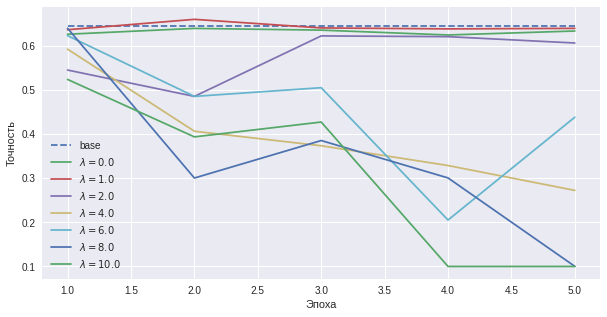

In [ ]:
plt.figure(figsize=(10,5))

base_acc = 0.6464342948717948
plt.plot([1, EPOCHS], [base_acc, base_acc], ls='--', label="base")

for lambd, accs in val_accs.items():
    if 0 < lambd and lambd < 1:
        continue
    plt.plot(np.arange(EPOCHS)+1, accs, label=f"$\lambda={lambd}$")

plt.ylabel('Точность')
plt.xlabel('Эпоха')

plt.legend()
plt.savefig('/content/drive/MyDrive/m1p/figs/learning_curve_for_lambdas.png', bbox_inches='tight')

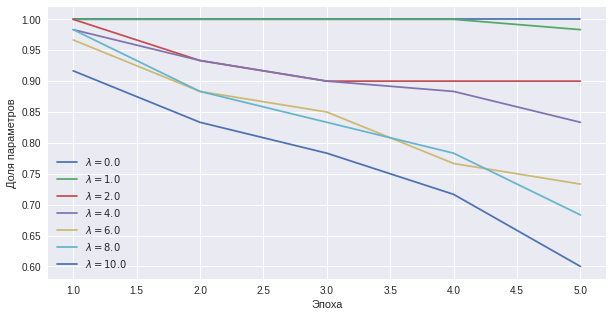

In [ ]:
plt.figure(figsize=(10,5))

base = 1
# plt.plot([1, EPOCHS], [base, base], ls='--', label="base")

for lambd, gamma_history in gammas.items():
    if 0 < lambd and lambd < 1:
        continue
    params_fraction = [gamma.cpu().mean() for gamma in gamma_history]
    plt.plot(np.arange(EPOCHS)+1, params_fraction, label=f"$\lambda={lambd}$")

plt.ylabel('Доля параметров')
plt.xlabel('Эпоха')

plt.legend()
plt.savefig('/content/drive/MyDrive/m1p/figs/params_curve_for_lambdas.png', bbox_inches='tight')

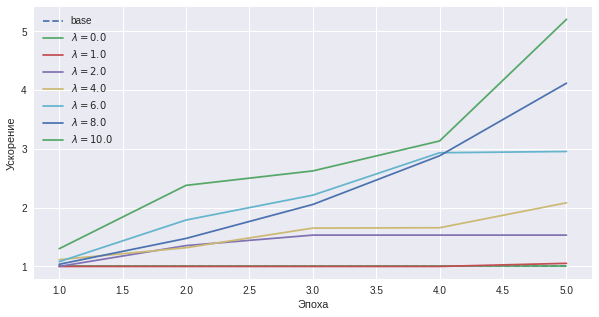

In [ ]:
plt.figure(figsize=(10,5))

base = 1
plt.plot([1, EPOCHS], [base, base], ls='--', label="base")

for lambd, gamma_history in gammas.items():
    if 0 < lambd and lambd < 1:
        continue
    accel = [1 / gamma.dot(times).cpu() for gamma in gamma_history]
    plt.plot(np.arange(EPOCHS)+1, accel, label=f"$\lambda={lambd}$")

plt.ylabel('Ускорение')
plt.xlabel('Эпоха')

plt.legend()
plt.savefig('/content/drive/MyDrive/m1p/figs/acceleration_curve_for_lambdas.png', bbox_inches='tight')

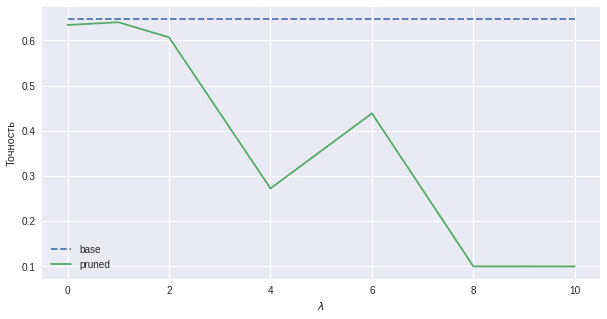

In [ ]:
plt.figure(figsize=(10,5))

base_acc = 0.6464342948717948
plt.plot([lambds[0], lambds[-1]], [base_acc, base_acc], ls='--', label="base")

final = [accs[-1] for _, accs in val_accs.items()]
plt.plot(lambds, final, label="pruned")

# plt.xscale('log')
plt.ylabel('Точность')
plt.xlabel('$\lambda$')

plt.legend()
plt.savefig('/content/drive/MyDrive/m1p/figs/accuracy_versus_lambda.png', bbox_inches='tight')